In [2]:
import tensorflow as tf
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [3]:

OUTPUT_CHANNELS = 2
def Generator():
  inputs = tf.keras.layers.Input(shape=[128, 128, 2])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 64, 64, 64)
    downsample(128, 4),  # (batch_size, 32, 32, 128)
    downsample(256, 4),  # (batch_size, 16, 16, 256)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
    # downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    # upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4),  # (batch_size, 8, 8, 1024)
    upsample(256, 4),  # (batch_size, 16, 16, 512)
    upsample(128, 4),  # (batch_size, 32, 32, 256)
    upsample(64, 4),  # (batch_size, 64, 64, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

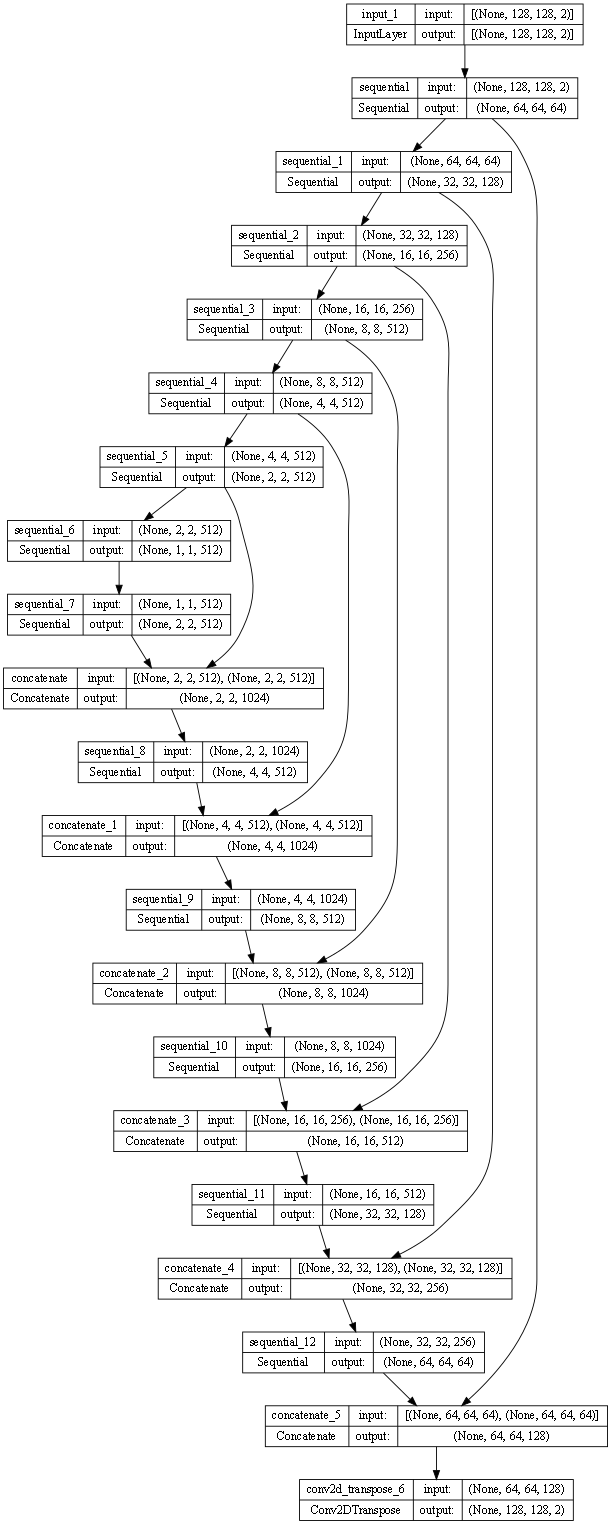

In [4]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
# generator.summary()

In [8]:
LAMBDA = 100
# loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_object = tf.keras.losses.CategoricalCrossentropy()
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [5]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[128, 128, 2], name='input_image')
  tar = tf.keras.layers.Input(shape=[128, 128, 2], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256/, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32/16, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34/18, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31/15, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33/17, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30/14, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

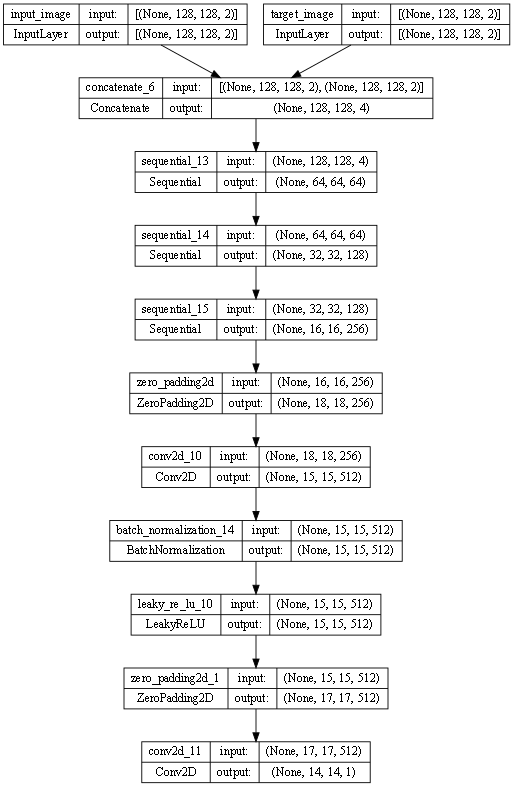

In [6]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [11]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [12]:
import keras
# 定义 pix2pix 模型，继承自 keras.Model
class Pix2Pix(keras.Model):
  # 初始化模型，传入生成器和判别器
  def __init__(self, generator, discriminator, lambda_=100):
    super(Pix2Pix, self).__init__()
    self.generator = generator
    self.discriminator = discriminator
    self.lambda_ = lambda_ # 用于控制生成器损失中的 L1 损失的权重
  # 定义模型的前向传播逻辑，传入输入图像和目标图像，返回生成器和判别器的输出
  def call(self, inputs, training=True):
    input_image, target_image = inputs
    gen_output = self.generator(input_image, training=training) # 生成器根据输入图像生成输出图像
    disc_real_output = self.discriminator([input_image, target_image], training=training) # 判别器根据输入图像和目标图像判断真假
    disc_generated_output = self.discriminator([input_image, gen_output], training=training) # 判别器根据输入图像和生成图像判断真假
    return gen_output, disc_real_output, disc_generated_output
  # 定义模型的自定义训练逻辑，传入输入图像和目标图像，计算损失值和梯度，更新权重，返回度量指标
  def train_step(self, inputs):
    input_image, target_image = inputs # 获取输入图像和目标图像
    # 使用 tf.GradientTape 记录梯度
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # 调用模型的前向传播逻辑，得到生成器和判别器的输出
      gen_output, disc_real_output, disc_generated_output = self(input_image, target_image, training=True)
      # 计算生成器和判别器的损失值
      gen_loss = self.generator_loss(disc_generated_output, gen_output, target_image)
      disc_loss = self.discriminator_loss(disc_real_output, disc_generated_output)
    # 计算生成器和判别器的梯度
    generator_gradients = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
    # 使用优化器更新生成器和判别器的权重
    self.optimizer.apply_gradients(zip(generator_gradients, self.generator.trainable_variables))
    self.optimizer.apply_gradients(zip(discriminator_gradients, self.discriminator.trainable_variables))
    # 返回生成器和判别器的损失值作为度量指标
    return {"gen_loss": gen_loss, "disc_loss": disc_loss}
 # 定义生成器的损失函数，包括对抗损失和 L1 损失
  def generator_loss(self, disc_generated_output, gen_output, target):
    gan_loss = self.loss_object(tf.ones_like(disc_generated_output), disc_generated_output) # 对抗损失，希望判别器判断生成图像为真
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output)) # L1 损失，希望生成图像接近目标图像
    total_gen_loss = gan_loss + (self.lambda_ * l1_loss) # 总损失，加权求和
    return total_gen_loss
  # 定义判别器的损失函数，包括真实图像的损失和生成图像的损失
  def discriminator_loss(self, disc_real_output, disc_generated_output):
    real_loss = self.loss_object(tf.ones_like(disc_real_output), disc_real_output) # 真实图像的损失，希望判别器判断真实图像为真
    generated_loss = self.loss_object(tf.zeros_like(disc_generated_output), disc_generated_output) # 生成图像的损失，希望判别器判断生成图像为假
    total_disc_loss = real_loss + generated_loss # 总损失，求和
    return total_disc_loss

In [13]:
p2p = Pix2Pix(generator, discriminator)

In [14]:
p2p.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [19]:
p2p.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [ ]:
def fit(train_ds, test_ds, epochs):
# 初始化最佳验证指标和最佳模型参数
    best_val_metric = float(“inf”) 
    best_weights = None
# 创建一个检查点管理器，用于保存和恢复模型
    checkpoint = tf.train.Checkpoint(model=model) 
    checkpoint_manager = tf.train.CheckpointManager(checkpoint, directory=“checkpoints”, max_to_keep=1)
# 遍历每个 epoch
    for epoch in range(epochs): # 遍历训练数据集的每个批次 
        for step, (input_image, target) in enumerate(train_ds): 
        # 调用自定义的训练步骤函数 
        train_step(input_image, target, step)
        # 每 10 个步骤打印一个点 
        if (step + 1) % 10 == 0: print(“.”, end=“”, flush=True) 
        # 在每个 epoch 结束时，打印当前的 epoch 和损失 
        print(f"\nEpoch {epoch + 1}, loss: {train_loss.result():.4f}") 
        # 重置训练损失和指标的状态 
        train_loss.reset_states() train_accuracy.reset_states() 
        # 遍历验证数据集的每个批次 
        for input_image, target in test_ds: 
        # 调用自定义的评估步骤函数 
        test_step(input_image, target) 
        # 打印当前的验证指标 
        print(f"Validation loss: {val_loss.result():.4f}, accuracy: {val_accuracy.result():.4f}") 
        # 如果当前的验证指标优于之前的最佳指标，更新最佳指标和最佳权重，并保存检查点 
        if val_loss.result() < best_val_metric: best_val_metric = val_loss.result() best_weights = model.get_weights() checkpoint_manager.save() 
        # 重置验证损失和指标的状态 
        val_loss.reset_states() val_accuracy.reset_states()
# 在训练结束后，恢复最佳权重
model.set_weights(best_weights)

### resnet

In [26]:
import keras
from keras.applications import resnet
from keras import layers
from keras import models
import numpy as np
# 加载预训练的 ResNet50 模型，去掉最后一层分类层
base_model = resnet.ResNet50(weights=None, include_top=False,input_shape=(128, 128, 2))
# 在模型的最后添加一个上采样层，将特征图放大到 128×128
x = layers.UpSampling2D(size=(4, 4))(base_model.output)

# 在模型的最后添加一个卷积层，将特征图转换为输出图像，激活函数为 tanh
output = layers.Conv2D(2, (3, 3), padding='same', activation='tanh')(x)

# 构建图像图像映射的网络，输入和输出都是 128×128×2 的图像
model = models.Model(inputs=base_model.input, outputs=output)
# 修改第一层卷积的输入通道数
# base_model.layers[1] = keras.layers.Conv2D(2, (7, 7), strides=(2, 2), padding='same', name='conv1_pad')
# model.summary()
# tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)
# model.compile(optimizer='adam',loss='mse')
# model.fit(np.random.random((128,128,2)),np.random.random((128,128,2)))
model.layers[0]

In [27]:
model.layers[1]